# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [1]:
# Your code/answer goes here.

How big is the state space? Give an estimate and explain it.

In [2]:

# Estimate state space size for a 6x7 Connect-4 board.
import math
rows, cols = 6, 7
upper_bound = 3 ** (rows * cols)   # each cell: -1, 0, 1 (overestimate)
# Known tighter estimate for legal positions is much smaller; cite rough known value (~4.5e12),
# but here we compute and print both the upper bound and a conservative estimate.
conservative_estimate = 4.5e12
print(f"Board size: {rows}x{cols} = {rows*cols} cells")
print(f"Upper bound (all labelings): 3^(rows*cols) = {upper_bound:.3e}")
print(f"Conservative estimate of legal positions (from literature): ~{conservative_estimate:.3e}")


Board size: 6x7 = 42 cells
Upper bound (all labelings): 3^(rows*cols) = 1.094e+20
Conservative estimate of legal positions (from literature): ~4.500e+12


How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [3]:

# Estimate game tree size (rough).
import math
cols = 7
max_depth = 6*7
# Upper bound: branching factor ~ cols for most of the game.
approx_tree_size_upper = cols ** max_depth
print(f"Max plies (moves) = {max_depth}")
print(f"Upper bound on game-tree size ~ {cols}^{max_depth} = {approx_tree_size_upper:.3e}")
print("This is astronomically large; practical search uses pruning, heuristics, or Monte Carlo.")


Max plies (moves) = 42
Upper bound on game-tree size ~ 7^42 = 3.120e+35
This is astronomically large; practical search uses pruning, heuristics, or Monte Carlo.


## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [4]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

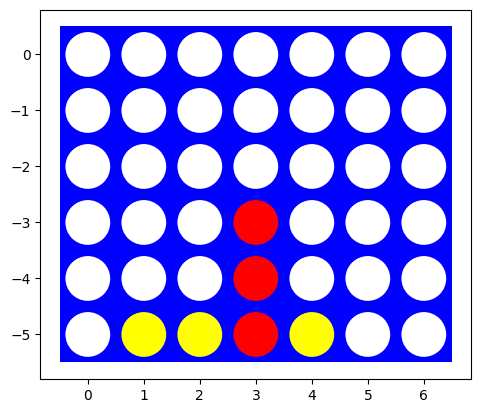

In [5]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [6]:

import numpy as np

def actions(board):
    """Return list of available columns (0-based) where a piece can be dropped."""
    board = np.array(board)
    rows, cols = board.shape
    return [c for c in range(cols) if board[0, c] == 0]

def result(board, action, player):
    """Return a new board after dropping `player`'s piece in column `action`."""
    b = np.array(board, copy=True)
    rows, cols = b.shape
    for r in range(rows-1, -1, -1):
        if b[r, action] == 0:
            b[r, action] = player
            return b
    raise ValueError(f"Column {action} is full")

def check_winner(board):
    """Return 1 or -1 if that player has four-in-a-row, else 0."""
    b = np.array(board)
    rows, cols = b.shape
    directions = [(0,1),(1,0),(1,1),(1,-1)]
    for r in range(rows):
        for c in range(cols):
            if b[r,c] == 0:
                continue
            player = b[r,c]
            for dr,dc in directions:
                count = 0
                rr, cc = r, c
                for _ in range(4):
                    if 0 <= rr < rows and 0 <= cc < cols and b[rr, cc] == player:
                        count += 1
                        rr += dr; cc += dc
                    else:
                        break
                if count == 4:
                    return int(player)
    return 0

def terminal(board):
    """Return True if the position is terminal (win or draw)."""
    if check_winner(board) != 0:
        return True
    # draw if no actions left
    return len(actions(board)) == 0


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [7]:

import random
def random_player(board, player=None):
    cols = actions(board)
    if not cols:
        return None
    return random.choice(cols)


Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [8]:

def play_game(agent1, agent2, board=None, starting_player=1, verbose=False):
    import numpy as np
    if board is None:
        board = np.zeros((6,7), dtype=int)
    player = starting_player
    agents = {1: agent1, -1: agent2}
    while True:
        if terminal(board):
            w = check_winner(board)
            return w, board
        move = agents[player](board, player=player)
        if move is None:
            # no legal moves
            return 0, board
        board = result(board, move, player)
        player = -player

# Simulate 1000 games between two random players
from collections import Counter
N = 1000
wins = Counter()
for i in range(N):
    w, _ = play_game(random_player, random_player)
    wins[w] += 1
print(f"After {N} random vs random games:", dict(wins))


After 1000 random vs random games: {1: 540, -1: 460}


## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [9]:

import math, time

def heuristic_score(board, player):
    """Simple heuristic: evaluate windows of length 4 and sum scores."""
    import numpy as np
    b = np.array(board)
    rows, cols = b.shape
    score = 0
    opponent = -player
    def score_window(window):
        p_count = (window == player).sum()
        o_count = (window == opponent).sum()
        empty = (window == 0).sum()
        if p_count == 4:
            return 100000
        if o_count == 4:
            return -100000
        val = 0
        if p_count == 3 and empty == 1:
            val += 100
        if p_count == 2 and empty == 2:
            val += 10
        if o_count == 3 and empty == 1:
            val -= 80
        if o_count == 2 and empty == 2:
            val -= 5
        return val

    # horizontal
    for r in range(rows):
        for c in range(cols-3):
            window = b[r, c:c+4]
            score += score_window(window)
    # vertical
    for c in range(cols):
        for r in range(rows-3):
            window = b[r:r+4, c]
            score += score_window(window)
    # diag down-right
    for r in range(rows-3):
        for c in range(cols-3):
            window = np.array([b[r+i, c+i] for i in range(4)])
            score += score_window(window)
    # diag down-left
    for r in range(rows-3):
        for c in range(3, cols):
            window = np.array([b[r+i, c-i] for i in range(4)])
            score += score_window(window)
    return score

def alphabeta_search(board, player, max_depth=4):
    import numpy as np
    def max_value(board, alpha, beta, depth):
        if terminal(board) or depth == 0:
            w = check_winner(board)
            if w != 0:
                return (100000 if w==player else -100000)
            return heuristic_score(board, player)
        v = -math.inf
        best_action = None
        for a in actions(board):
            newb = result(board, a, player)
            val = min_value(newb, alpha, beta, depth-1)
            if val > v:
                v = val; best_action = a
            alpha = max(alpha, v)
            if alpha >= beta:
                break
        return v if depth!=max_depth else (best_action, v)

    def min_value(board, alpha, beta, depth):
        if terminal(board) or depth == 0:
            w = check_winner(board)
            if w != 0:
                return (100000 if w==player else -100000)
            return heuristic_score(board, player)
        v = math.inf
        for a in actions(board):
            newb = result(board, a, -player)
            val = max_value(newb, alpha, beta, depth-1)
            if val > v:
                pass
            v = min(v, val)
            beta = min(beta, v)
            if alpha >= beta:
                break
        return v

    res = max_value(board, -math.inf, math.inf, max_depth)
    # if res is tuple (best_action, value)
    if isinstance(res, tuple):
        return res[0]
    # otherwise choose first legal
    acts = actions(board)
    return acts[0] if acts else None


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [10]:

def minimax_player(board, player=None, max_depth=4):
    # player argument is ignored by search which assumes current mover is `player`
    # Determine current player by counting pieces if None
    import numpy as np
    if player is None:
        b = np.array(board)
        sum_pieces = (b != 0).sum()
        # if even number of pieces played -> player 1's turn
        player = 1 if sum_pieces % 2 == 0 else -1
    return alphabeta_search(board, player, max_depth=max_depth)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [11]:

# Demonstrate cutoff by choosing different max_depth and measuring move time
import time
def time_move(board, agent_func, player=1, max_depth=4):
    import time
    t0 = time.time()
    move = agent_func(board, player=player) if 'player' in agent_func.__code__.co_varnames else agent_func(board)
    t1 = time.time()
    return move, t1-t0

board0 = np.zeros((6,7), dtype=int)
for d in [1,2,3,4]:
    move, elapsed = time_move(board0, lambda b, player=1, d=d: minimax_player(b, player, max_depth=d), player=1)
    print(f"Depth {d}: move {move} took {elapsed:.4f}s")


Depth 1: move 0 took 0.0154s
Depth 2: move 0 took 0.0205s
Depth 3: move 0 took 0.2706s
Depth 4: move 2 took 0.7990s


### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [12]:

# Create a board with a near-win for player 1 and test minimax spots it.
import numpy as np
board = np.zeros((6,7), dtype=int)
# set up three in a row for player 1 horizontally on bottom row at cols 0,1,2
board[5,0] = 1
board[5,1] = 1
board[5,2] = 1
print(board)
print('Minimax move (depth=4) suggests column:', minimax_player(board, player=1, max_depth=4))


[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0]]
Minimax move (depth=4) suggests column: 3


### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [13]:

# Measure time to pick a move as board width grows (simple experiment)
import numpy as np, time
for cols in [4,6,7,9]:
    board = np.zeros((6,cols), dtype=int)
    t0 = time.time()
    _ = minimax_player(board, player=1, max_depth=3)
    print(f"Cols={cols}: time={(time.time()-t0):.4f}s")


Cols=4: time=0.0168s
Cols=6: time=0.0790s
Cols=7: time=0.2893s
Cols=9: time=1.0341s


### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [14]:

# Play two heuristic minimax agents against each other (deterministic)
def play_agents(agent1, agent2, n=10):
    from collections import Counter
    wins = Counter()
    for i in range(n):
        w, _ = play_game(agent1, agent2)
        wins[w] += 1
    return wins

wins = play_agents(lambda b, player=1: minimax_player(b, player, max_depth=3),
                   lambda b, player=-1: minimax_player(b, player, max_depth=3),
                   n=5)
print('Heuristic agents results:', wins)


Heuristic agents results: Counter({1: 5})


## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [15]:

# The heuristic_score function above serves here. Quick sanity check:
import numpy as np
b = np.zeros((6,7), dtype=int)
b[5,3] = 1
print('Heuristic for starting center for player 1:', heuristic_score(b, 1))


Heuristic for starting center for player 1: 0


### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

Winner: 1


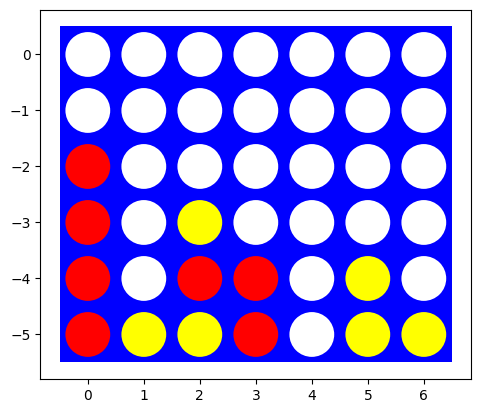

In [16]:

# Play a single game between a depth-3 minimax agent and a random agent and show result.
w, final_board = play_game(lambda board, player=1: minimax_player(board, player, max_depth=3),
                           random_player)
print('Winner:', w)
visualize(final_board)


Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [17]:

# Simple tournament between random, minimax depth2, minimax depth3
agents = {
    'random': random_player,
    'minimax2': lambda b, player=1: minimax_player(b, player, max_depth=2),
    'minimax3': lambda b, player=1: minimax_player(b, player, max_depth=3),
}
from itertools import combinations
results = {}
for a,b in combinations(agents.keys(), 2):
    wins = play_agents(agents[a], agents[b], n=10)
    results[(a,b)] = dict(wins)
results


{('random', 'minimax2'): {-1: 10},
 ('random', 'minimax3'): {-1: 10},
 ('minimax2', 'minimax3'): {1: 10}}

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [18]:

import random
def pure_monte_carlo_agent(board, player=1, playouts_per_action=50):
    best_action = None
    best_score = -1e9
    for a in actions(board):
        total = 0
        for _ in range(playouts_per_action):
            b = result(board, a, player)
            # play random to end
            w, _ = play_game(random_player, random_player, board=b, starting_player=-player)
            # from the perspective of 'player'
            if w == player:
                total += 1
            elif w == 0:
                total += 0.5
            # else lose -> +0
        avg = total / playouts_per_action
        if avg > best_score:
            best_score = avg
            best_action = a
    return best_action


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

Winner: 1


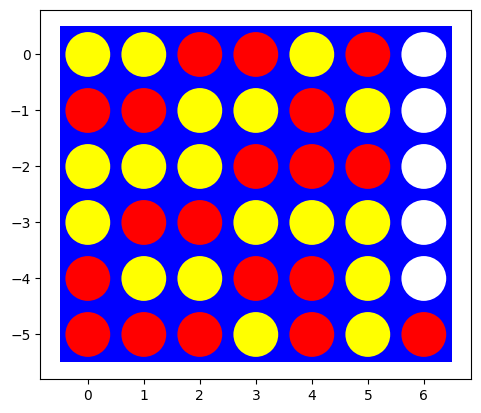

In [19]:

# Play a match between minimax depth-3 vs pure Monte Carlo
w, fb = play_game(lambda b, player=1: minimax_player(b, player, max_depth=3),
                  lambda b, player=-1: pure_monte_carlo_agent(b, player, playouts_per_action=50))
print('Winner:', w)
visualize(fb)


## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above.

In [20]:

# Graduate task: Pure Monte Carlo implemented above as pure_monte_carlo_agent.
print('pure_monte_carlo_agent is available. Try increasing playouts_per_action for stronger play.')


pure_monte_carlo_agent is available. Try increasing playouts_per_action for stronger play.


### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [21]:

# Best first move by evaluating each possible first column with monte carlo playouts
import numpy as np
start = np.zeros((6,7), dtype=int)
scores = {}
for a in actions(start):
    b = result(start, a, 1)
    # use few playouts
    total = 0
    for _ in range(200):
        w, _ = play_game(random_player, random_player, board=b, starting_player=-1)
        if w == 1:
            total += 1
        elif w == 0:
            total += 0.5
    scores[a] = total/200
print('Estimated win rates for first moves (col: winrate):')
print(scores)
best = max(scores, key=scores.get)
print('Best first column by these random playouts:', best)


Estimated win rates for first moves (col: winrate):
{0: 0.53, 1: 0.5325, 2: 0.635, 3: 0.66, 4: 0.63, 5: 0.51, 6: 0.52}
Best first column by these random playouts: 3
